# Данные

In [51]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

corp_col = '#40ba21'


In [52]:

df = pd.read_csv("Never Trust Summary Statistics.tsv", delimiter="\t")
df["dataset"].unique()

array(['dino', 'away', 'h_lines', 'v_lines', 'x_shape', 'star',
       'high_lines', 'dots', 'circle', 'bullseye', 'slant_up',
       'slant_down', 'wide_lines'], dtype=object)

## Выберем в качестве бинарной переменной колонку dataset, присвоив 1 фигуре "wide_lines", остальным 0, то есть задача будет сводится к определению относится ли конкретная точка в массиве к фигуре "wide_lines" или нет.

In [53]:
df.loc[df["dataset"] != 'wide_lines', "dataset"] = 0
df.loc[df["dataset"] == 'wide_lines', "dataset"] = 1
df["dataset"] = df["dataset"].astype(int)

In [54]:
df

,dataset,x,y
0,0,55.384600,97.179500
1,0,51.538500,96.025600
2,0,46.153800,94.487200
3,0,42.820500,91.410300
4,0,40.769200,88.333300
...,...,...,...
1841,1,33.674442,26.090490
1842,1,75.627255,37.128752
1843,1,40.610125,89.136240
1844,1,39.114366,96.481751


# Домашнее задание 7

## Обучающая и тестовая выборки.

Так как в общем наборе данных точки относящиеся к "wide_lines" составляют всего 8%, то есть массив не сбалансирован, то используем параметр stratify=y

In [55]:
from sklearn.model_selection import train_test_split

X = df.drop(['dataset'], axis=1) # X — признаки (features)
y = df[['dataset']]              # y — целевая переменная (label)

# Разделение на обучающую и тестовую выборки, так как в общем наборе данных точки относящиеся к "wide_lines" составляют всего 8%, то есть массив не сбалансирован, то используем параметр stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train

,x,y
1753,34.548619,26.111088
932,63.609380,83.360029
429,50.326911,90.022053
293,22.955093,70.426895
1617,61.737271,38.584844
...,...,...
175,28.236782,56.139596
458,50.333481,43.588671
413,56.772150,10.503272
1782,66.313810,98.931027


## Обучение базовой модели опорных вектрорв (SVM)

### Так как объясняющие переменные это координаты и они в одном масштабе, то нет смысла использовать стандартизацию переменных.

### Так как точки относяшиеся к фигуре "wide_lines" не могут быть отделены от других точек прямой попробуем сразу ядро RBF.

### Кроме того, так как данные не сбалансированы, то укажем параметр class_weight='balanced'

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Создание объекта SVM
svm_basic = SVC(kernel='rbf', random_state=42, class_weight='balanced')

# Обучение модели на подготовленных тренировочных данных
svm_basic.fit(X_train, y_train)

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(class_weight='balanced', random_state=42)

### Функция рисования разделительной линии

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


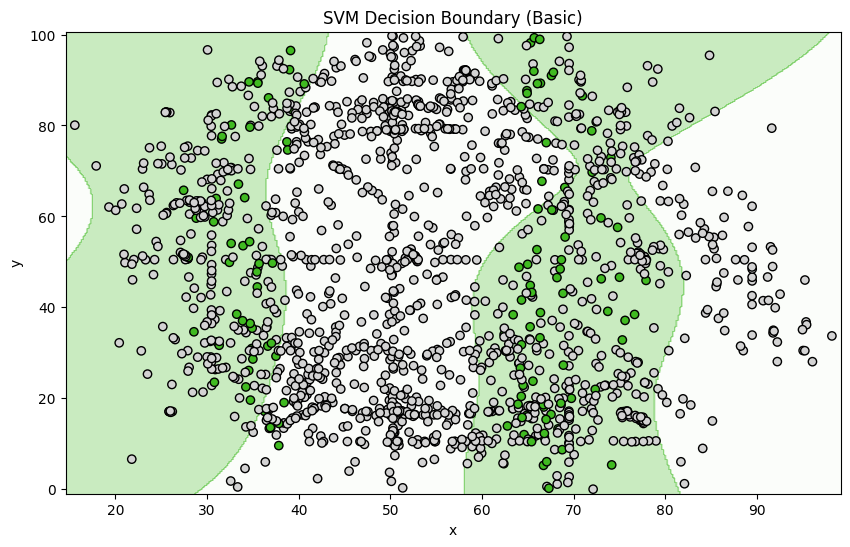

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot decision boundary
def plot_decision_boundary(model, X, y, title):
    h = 0.2  # Step size in mesh
    x_min, x_max = X['x'].min() - 1, X['x'].max() + 1
    y_min, y_max = X['y'].min() - 1, X['y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Create custom colormap based on #40ba21
    from matplotlib.colors import LinearSegmentedColormap
    corp_green = '#40ba21'
    cmap_green = LinearSegmentedColormap.from_list('green_cmap', 
                                                 ['white', corp_green])
    
    plt.figure(figsize=(10, 6))
    
    # Plot decision regions with green colormap
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_green)
    
    # Plot data points - using green for class 1, gray for class 0
    colors = ['lightgray' if val == 0 else corp_green for val in y.values.ravel()]
    plt.scatter(X['x'], X['y'], c=colors, edgecolors='k')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

plot_decision_boundary(svm_basic, X_train, y_train, "SVM Decision Boundary (Basic)")

### В целом видно что модель смогла определить оба региона с точками класса 1, но довольно грубо. Попробуем оптимизировать параметр 'С', используя GridSearch. Оптимизировать параметры будем по параметру Precision.


In [58]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    #'gamma': ['auto'], # ga
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(random_state=42,class_weight='balanced'),
    param_grid,
    scoring='precision',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'C': 100, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.1863


f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Наилучшее значение параметра С оказалось равным 100.

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


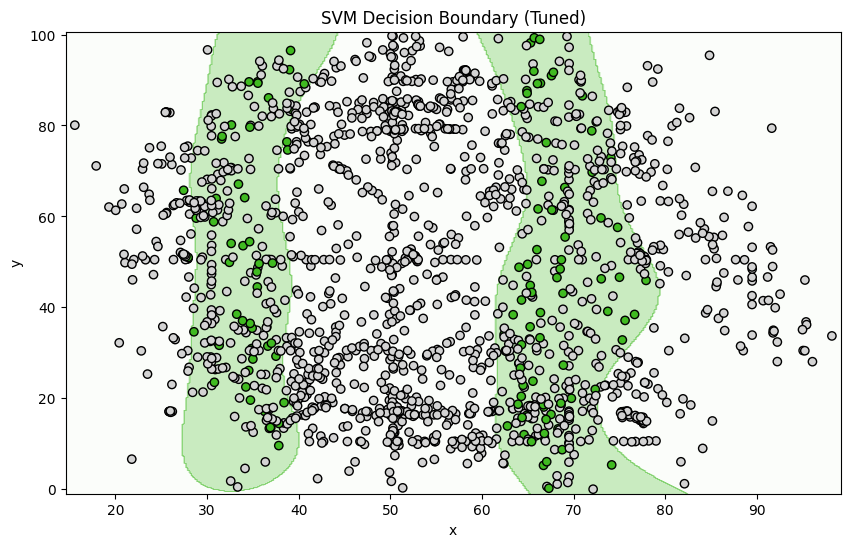

In [59]:
# Plot decision boundary for tuned model
plot_decision_boundary(best_svm, X_train, y_train, "SVM Decision Boundary (Tuned)")

### Точность определения региона значительно выросла, что видно как на тренировочной так и на тестовой выборке.

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


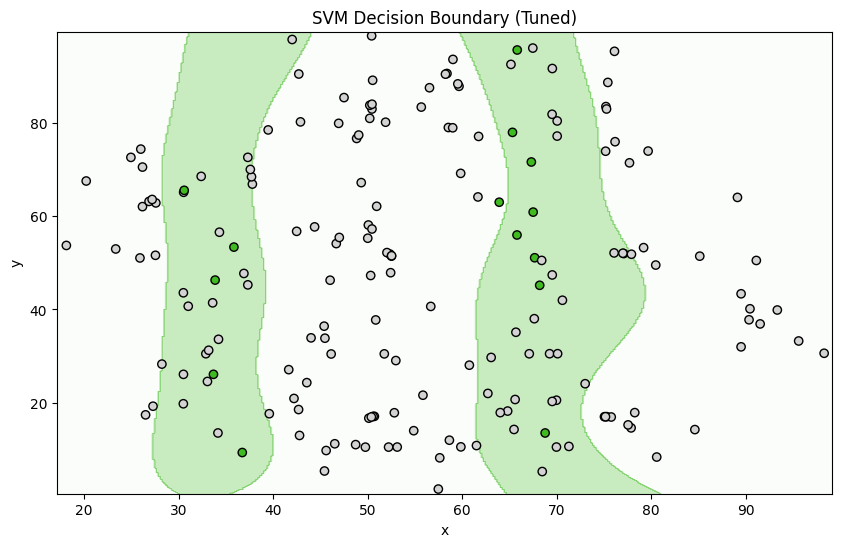

In [60]:
plot_decision_boundary(best_svm, X_test, y_test, "SVM Decision Boundary (Tuned)")

## Предсказание и матрица ошибок для базовой модели

In [61]:
predictions = svm_basic.predict(X_test)

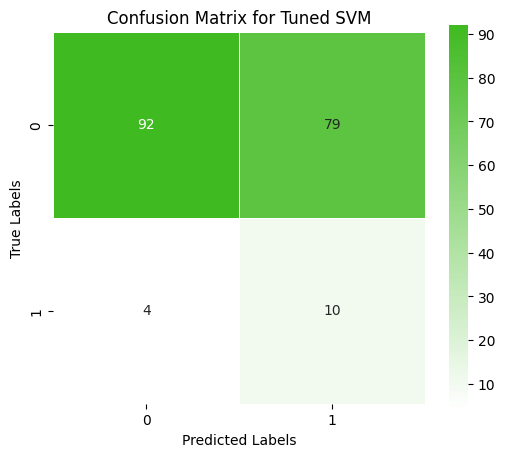

In [62]:
# Матрица ошибок для SVM
cm = confusion_matrix(y_test, predictions)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
from matplotlib.colors import LinearSegmentedColormap
c_map = LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Tuned SVM")
plt.show()

## Предсказание и матрица ошибок для базовой модели

In [63]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

# Ручной расчет метрик
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
specificity_manual = TN / (TN + FP)
f1_manual = 2 * ((precision_manual * recall_manual) / (precision_manual + recall_manual))
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)

print("\nМетрики:")
print(f"Прецизионность (Precision): {precision_manual:.3f}")
print(f"Полнота (Recall): {recall_manual:.3f}")
print(f"Специфичность (Specificity): {specificity_manual:.3f}")
print(f"F1-Score: {f1_manual:.3f}")
print(f"Общая точность (Accuracy): {accuracy_manual:.3f}")


Метрики:
Прецизионность (Precision): 0.112
Полнота (Recall): 0.714
Специфичность (Specificity): 0.538
F1-Score: 0.194
Общая точность (Accuracy): 0.551


### У базовой модели Precision на уровне 11%, что выше случйного гадания, но всё равно низкий результат (много ошибочно отнесённых к классу 1 точек), Recall на уровне 71% (было найдено 70% точек из класса 1).

## Предсказание и матрица ошибок для улучшенной модели

In [64]:
best_predictions = best_svm.predict(X_test)

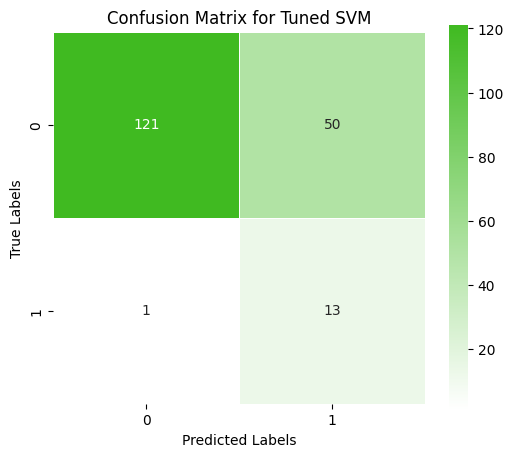

In [65]:

# Confusion matrix for tuned SVM
cm = confusion_matrix(y_test, best_predictions)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
from matplotlib.colors import LinearSegmentedColormap
c_map = LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Tuned SVM")
plt.show()

In [66]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

# Ручной расчет метрик
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
specificity_manual = TN / (TN + FP)
f1_manual = 2 * ((precision_manual * recall_manual) / (precision_manual + recall_manual))
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)

print("\nМетрики:")
print(f"Прецизионность (Precision): {precision_manual:.3f}")
print(f"Полнота (Recall): {recall_manual:.3f}")
print(f"Специфичность (Specificity): {specificity_manual:.3f}")
print(f"F1-Score: {f1_manual:.3f}")
print(f"Общая точность (Accuracy): {accuracy_manual:.3f}")


Метрики:
Прецизионность (Precision): 0.206
Полнота (Recall): 0.929
Специфичность (Specificity): 0.708
F1-Score: 0.338
Общая точность (Accuracy): 0.724


### У базовой модели Precision достиг 20%, но всё равно низкий результат (ошибочно отнесённых к классу 1 точек стало почти в два раза меньше), Recall уже 93% (была не найденвсего одна точка из класса 1).

# Общие выводы

### SVM в отличии от логистической регрессии оказалась способна на основе координат, хоть и с низкой Precision (20%) выделить интересующую нас фигуру. Точность оказалась уже значительно выше уровня случайного гадания.

In [67]:
# График разброса
fig = px.scatter(df.loc[ df["dataset"] == 1, :], x='x', y='y', color_discrete_sequence=[corp_col], size_max=10)

# Фон и подписи
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Вещественная переменная X',
    yaxis_title='Вещественная переменная Y'
)

fig.show()